In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q comet_ml transformers datasets gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [3]:
import comet_ml

# Initializing the project
comet_ml.init(project_name="text-classification-with-transformers")

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ·························


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [4]:
from huggingface_hub import notebook_login

#logging hugging face
notebook_login()

In [5]:
from datasets import load_dataset

# load the dataset
raw_datasets = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes_movie_review downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [7]:
# looking at sample data from training set
raw_datasets["train"][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [8]:
import pandas as pd

# Convert the dataset into pandas dataframe
raw_datasets.set_format(type="pandas")
df = raw_datasets["train"][:]
df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [9]:
def label_int2str(row):
    return raw_datasets["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,the rock is destined to be the 21st century's ...,1,pos
1,"the gorgeously elaborate continuation of "" the...",1,pos
2,effective but too-tepid biopic,1,pos
3,if you sometimes like to go to the movies to h...,1,pos
4,"emerges as something rare , an issue movie tha...",1,pos


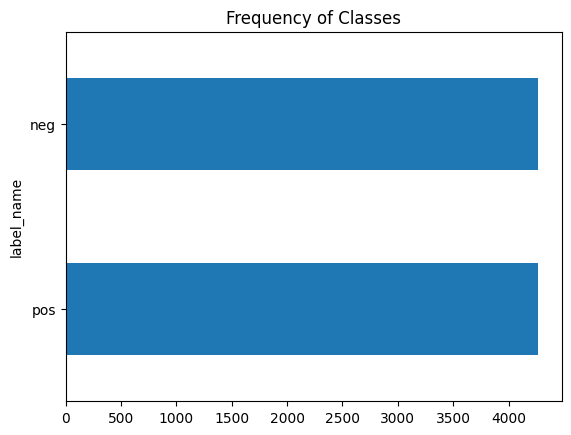

In [10]:
import matplotlib.pyplot as plt

#Visualize the frequency of classes
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

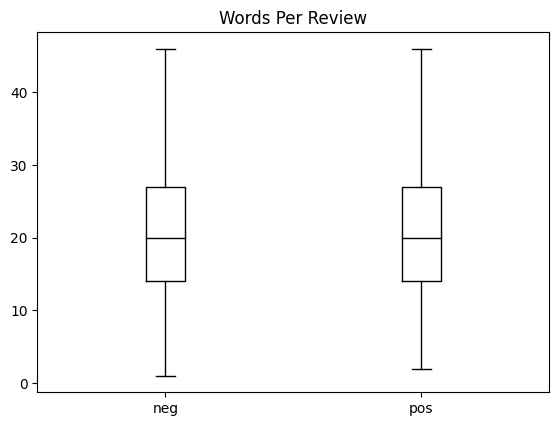

In [11]:
# Visualize words per review
df["Words Per Review"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Review", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
raw_datasets.reset_format()

In [13]:
from transformers import AutoTokenizer

#Loading the DistilBERT tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
# creating a function for tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Apply the function to the whole dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [15]:
from transformers import DataCollatorWithPadding

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Indexing to example function
def get_example(index):
    return tokenized_datasets["test"][index]["text"]

# Creating a function to compute metrics
def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment()
    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    
    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
        y_true=labels,
        y_predicted=preds,
        file_name=f"confusion-matrix-epoch-{epoch}.json",
        labels=["negative", "positive"],
        index_to_example_function=get_example,
        )
        
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [19]:
from transformers import AutoModelForSequenceClassification

# Mapping ids to labels
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# Building the model
model = AutoModelForSequenceClassification.from_pretrained( checkpoint, num_labels=2, id2label=id2label, label2id=label2id)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments, Trainer

# Setting Comet environment variables
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

#Setting training arguments
training_args = TrainingArguments(output_dir="my_distilbert_model", learning_rate=2e-5,
                                 per_device_train_batch_size=16,
                                 per_device_eval_batch_size=16,
                                 num_train_epochs=3,
                                 weight_decay=0.01,
                                 evaluation_strategy="epoch",
                                 save_strategy="epoch",
                                 load_best_model_at_end=True,
                                 push_to_hub=True,
                                 report_to=["comet_ml"],
                                 )
# Creating a trainer object
trainer = Trainer(model=model,
                 args=training_args,
                 train_dataset=tokenized_datasets["train"],
                 eval_dataset=tokenized_datasets["test"],
                 compute_metrics=compute_metrics,
                 data_collator=data_collator,
                 )
# Train the model
trainer.train()

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ad603-tech/text-classification-with-transformers/11fdc9307cd54cb588800d87d856ab91

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.424000,0.375824,0.838649,0.838444,0.840379,0.838649
2,0.251400,0.457145,0.844278,0.844137,0.845523,0.844278
3,0.162500,0.538838,0.846154,0.846153,0.846159,0.846154


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ad603-tech/text-classification-with-transformers/11fdc9307cd54cb588800d87d856ab91
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [7]                   : (0.94, 3.0)
COMET INFO:     eval_accuracy [3]           : (0.8386491557223265, 0.8461538461538461)
COMET INFO:     eval_f1 [3]                 : (0.8384438617267242, 0.8461533046098393)
COMET INFO:     eval_loss [3]               : (0.3758241534233093, 0.5388376116752625)
COMET INFO:     eval_precision [3]          : (0.840379274354756, 0.846158720101378)
COMET INFO:     eval_recall [3]             : (0.8386491557223265, 0.8461538461538463)
COMET INFO:     eval_

TrainOutput(global_step=1602, training_loss=0.27112192339664987, metrics={'train_runtime': 117.7052, 'train_samples_per_second': 217.408, 'train_steps_per_second': 13.61, 'total_flos': 321971326547376.0, 'train_loss': 0.27112192339664987, 'epoch': 3.0})

In [21]:
# Pushing the model
trainer.push_to_hub()

'https://huggingface.co/Adirobot/my_distilbert_model/tree/main/'

In [22]:
from transformers import pipeline

# Creating a text
text = "This is a great movie. It may be my favourite."

# Predicting the label
classifier = pipeline("sentiment-analysis", 
                       model="Adirobot/my_distilbert_model")
classifier(text)

[{'label': 'POSITIVE', 'score': 0.9508472084999084}]

In [3]:
import gradio as gr
from transformers import pipeline

# Creating pipeline
classifier = pipeline("sentiment-analysis", model="Adirobot/my_distilbert_model")

#Creating a function for text classification
def text_classification(text):
    result = classifier(text)
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    formatted_output = f"This sentiment is {sentiment_label} with the probability {sentiment_score*100:.2f}%"
    return formatted_output

# Getting examples
examples = ["This is wonderful movie!", "The movies was really bad; I didn't like it."]
    
# Building the gradio interface
io = gr.Interface(fn=text_classification,
                     inputs=gr.Textbox(lines=2, label="Text", placeholder="Enter title here...."),
                     outputs=gr.Textbox(lines=2, label="Text Classification Result"),
                     title="Text Classification",
                     description="Enter a text and see the text classification result!",
                     examples=examples)
    
io.launch(inline=False, share=True)
    
# Logging the app to the comet Dashboard
#experiment = comet_ml.Experiment()
#experiment.add_tag("text-classifier")
    
#Integrating Comet
#io.integrate(comet_ml=experiment)
    

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
comet_ml is installed but `COMET_API_KEY` is not set.


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://18fae36fe1bc03afdc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
